In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import time
from pythonosc import udp_client

In [43]:
# !pip install python-osc

  Cache entry deserialization failed, entry ignored
You are using pip version 9.0.3, however version 23.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Weather dataset

In [2]:
fpath = 'weatherData.csv'
df = pd.read_csv(fpath)

In [3]:
def remove_duplicates(df, column_date):
    df = df.drop_duplicates(subset=column_date)
    return df

def get_date_hour(df, column_date):
    df['Date'] = df[column_date].dt.date
    df['Hour'] = df[column_date].dt.hour
    return df

In [4]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'],utc=True)
df.sort_values(by='Formatted Date', inplace=True)
df = get_date_hour(df, 'Formatted Date')

columns =  df.columns.tolist()
df = remove_duplicates(df, columns[0])

In [5]:
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,Date,Hour
2880,2005-12-31 23:00:00+00:00,Partly Cloudy,rain,0.577778,-4.050000,0.89,17.1143,140.0,9.9820,0.0,1016.66,Mostly cloudy throughout the day.,2005-12-31,23
2881,2006-01-01 00:00:00+00:00,Mostly Cloudy,rain,1.161111,-3.238889,0.85,16.6152,139.0,9.9015,0.0,1016.15,Mostly cloudy throughout the day.,2006-01-01,0
2882,2006-01-01 01:00:00+00:00,Mostly Cloudy,rain,1.666667,-3.155556,0.82,20.2538,140.0,9.9015,0.0,1015.87,Mostly cloudy throughout the day.,2006-01-01,1
2883,2006-01-01 02:00:00+00:00,Overcast,rain,1.711111,-2.194444,0.82,14.4900,140.0,9.9015,0.0,1015.56,Mostly cloudy throughout the day.,2006-01-01,2
2884,2006-01-01 03:00:00+00:00,Mostly Cloudy,rain,1.183333,-2.744444,0.86,13.9426,134.0,9.9015,0.0,1014.98,Mostly cloudy throughout the day.,2006-01-01,3


In [6]:
columns

['Formatted Date',
 'Summary',
 'Precip Type',
 'Temperature (C)',
 'Apparent Temperature (C)',
 'Humidity',
 'Wind Speed (km/h)',
 'Wind Bearing (degrees)',
 'Visibility (km)',
 'Loud Cover',
 'Pressure (millibars)',
 'Daily Summary',
 'Date',
 'Hour']

In [7]:
# Retrieve a column from df as an array
def get_column(df, column):
    return df[column].values

# Write a function to plot any column in the dataframe, with numeric values, against the date column
def plot_column(df, column_date, column):
    print (column)
    df.sort_values(by=column_date, inplace=True)
    plt.figure(figsize = (20, 8))
    x = df[column_date].values
    y = df[column].values
    plt.plot(x, y)
    plt.title(str(column))
    plt.show()

In [8]:
# Write a function returns a new dataframe containing average of column values by date in the original dataframe
def get_average_by_date(df, column):
    df = df.groupby('Date')[column].mean().reset_index()
    return df

In [9]:
df_aggregate_temp = get_average_by_date(df, columns[3])
df_aggregate_humidity = get_average_by_date(df, columns[5])
df_aggregate_ws = get_average_by_date(df, columns[6])
df_aggregate_vis = get_average_by_date(df, columns[8])
df_aggregate_press = get_average_by_date(df, columns[10])

In [10]:
def plot_aggregates(df):
    plt.figure(figsize = (20, 8))
    cols = df.columns.tolist()
    x = df[cols[0]].values
    y = df[cols[1]].values
    plt.plot(x, y)
    plt.title(str(cols[1]))
    plt.show()

Temperature (C)


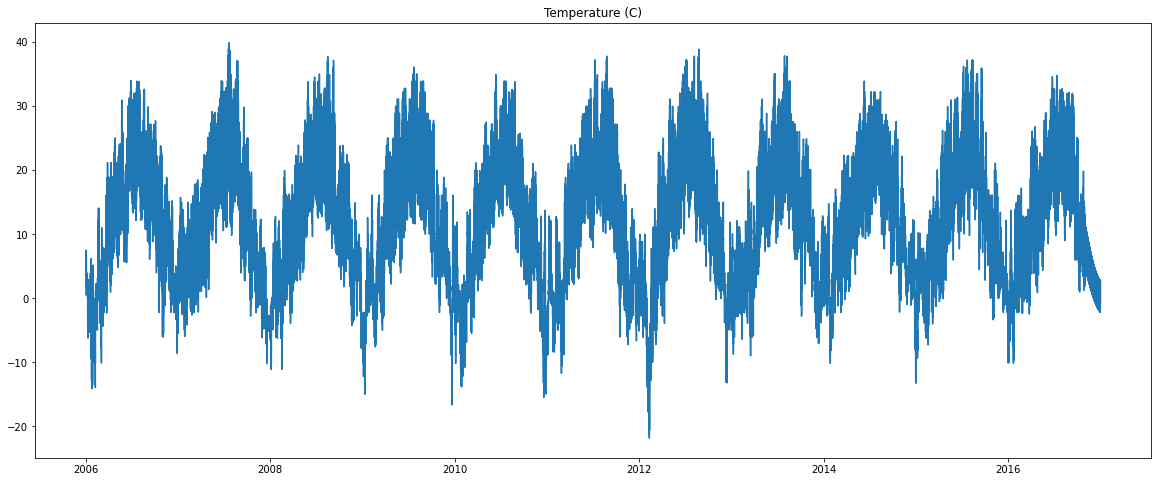

In [90]:
plot_column(df, columns[0], columns[3])

Humidity


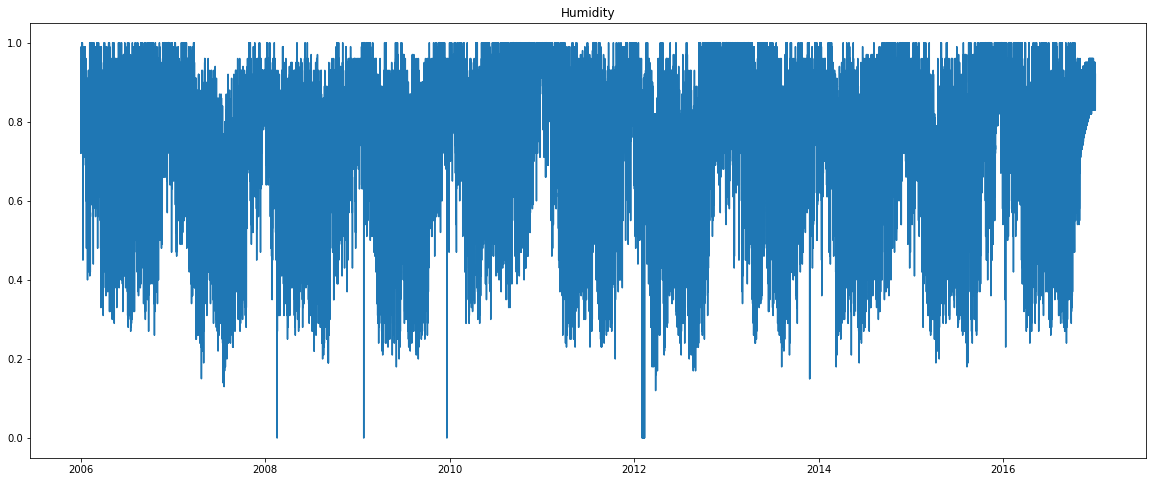

In [95]:
plot_column(df, columns[0], columns[5])

Wind Speed (km/h)


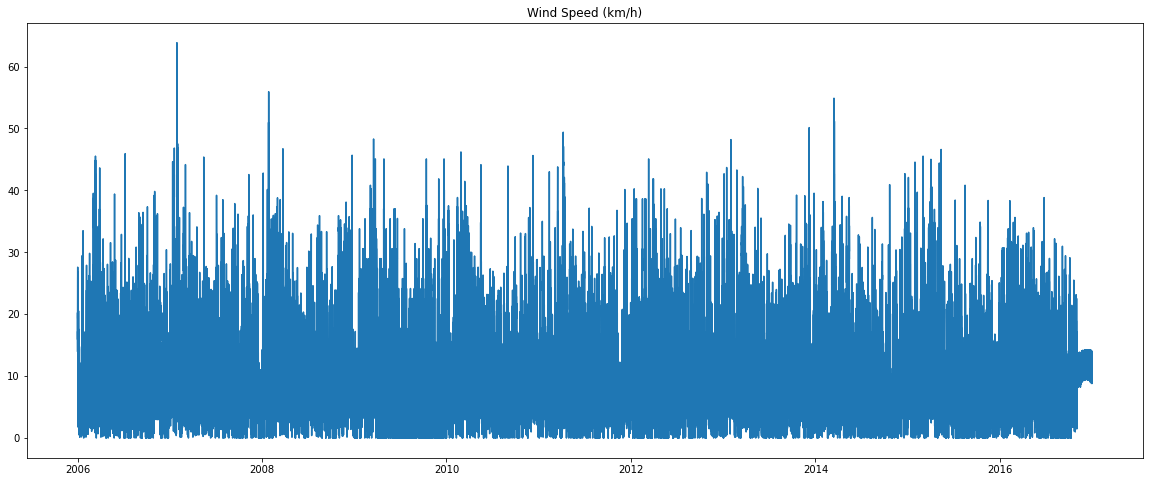

In [97]:
plot_column(df, columns[0], columns[6])

Wind Bearing (degrees)


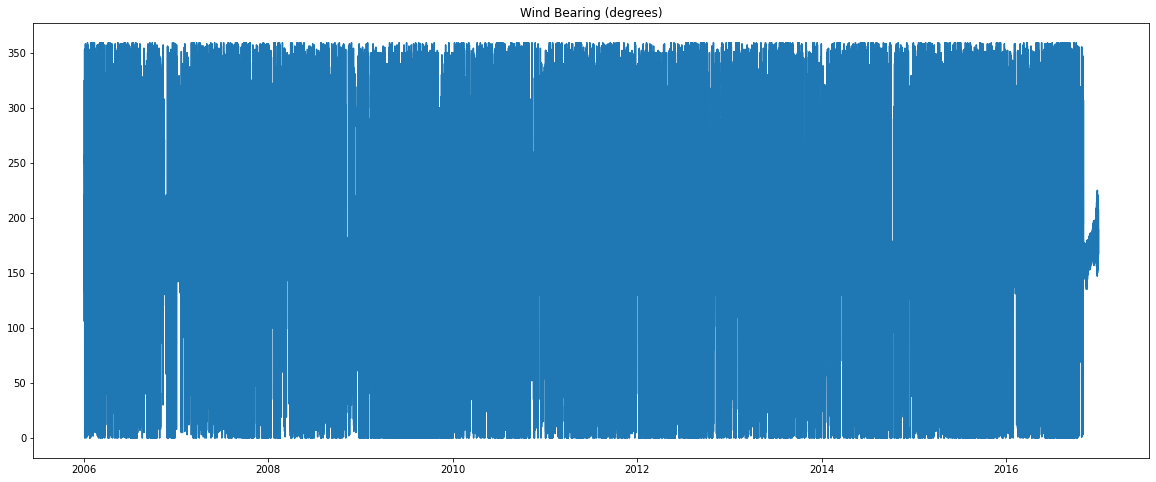

In [99]:
plot_column(df, columns[0], columns[7])

Visibility (km)


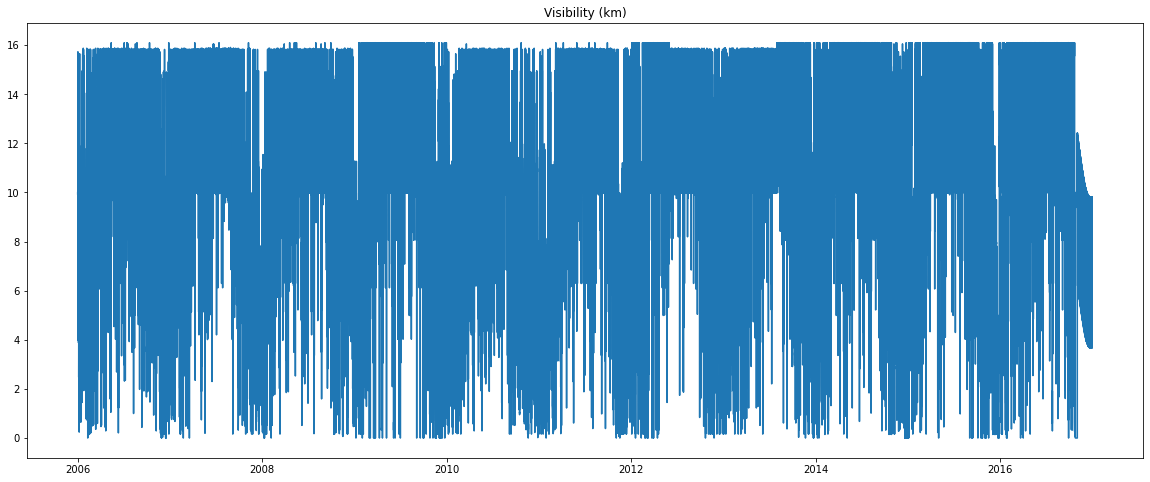

In [100]:
plot_column(df, columns[0], columns[8])

Pressure (millibars)


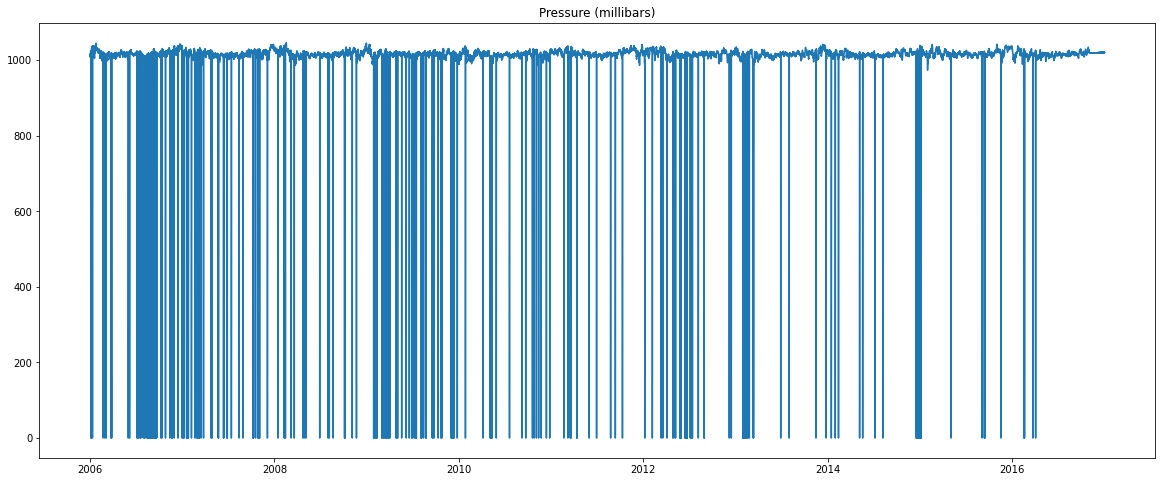

In [102]:
plot_column(df, columns[0], columns[10])

4019


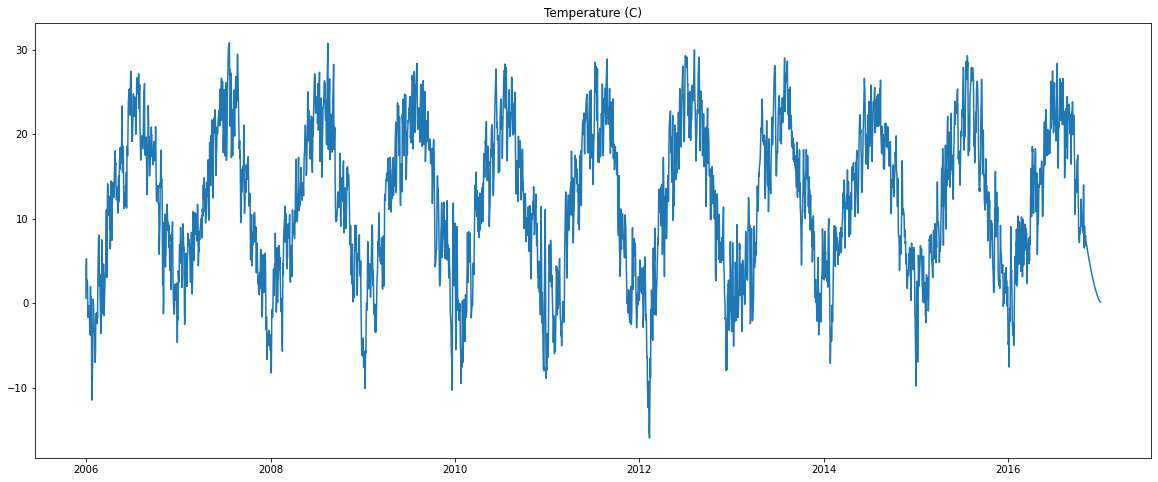

In [25]:
print (len(df_aggregate_temp))
plot_aggregates(df_aggregate_temp)

4019


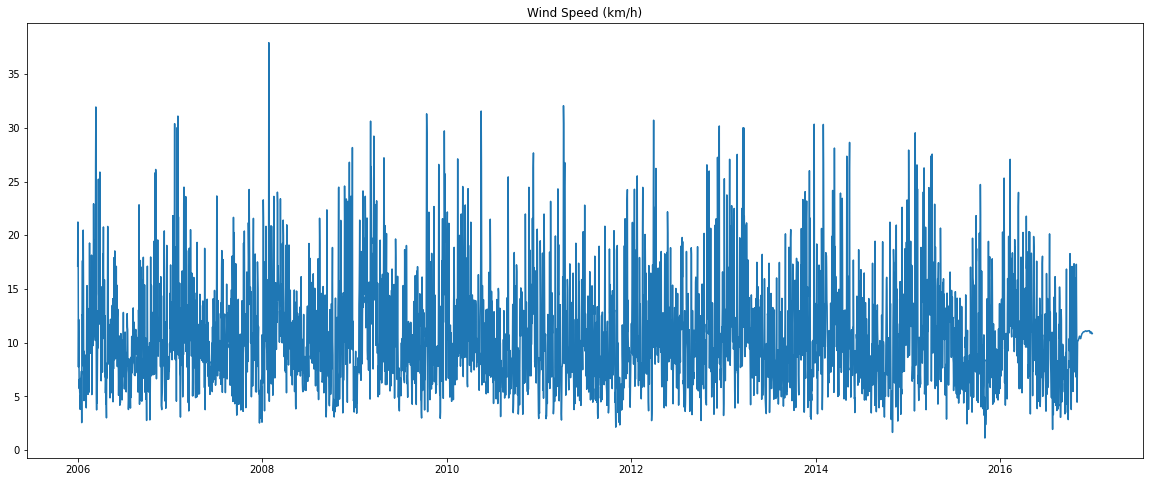

In [24]:
print (len(df_aggregate_ws))
plot_aggregates(df_aggregate_ws)

In [48]:
# Write a function to group data by formatted date column and count the number of entries for each date
def group_by_date(df, column_date, column):
    df_grouped = df.groupby([column_date]).count()
    return df_grouped

### Map streams to music parameters

#### Curently the whole song will  be mapped to just one scale across octaves 1-5. This is a simple approach. In future, can assign probabilities to switch keys based on some other parameter like windspeed.

#### Current mapping: Temperature <-> Scale; Pressure <-> Velcoty

#### TODO: Key change probability <-> Humidity. or may be  low humidity = major. Phrygian for something that describes middle eastern  conditions.

In [11]:
scale_dict = {
    "M": np.array([0, 2, 4, 5, 7, 9, 11]),
    "m": np.array([0, 2, 3, 5, 7, 8, 10]),
    "d": np.array([0, 2, 3, 5, 7, 9, 10]),
    "mP": np.array([0, 3, 5, 7, 10]),
}

root_note_midi = {
    "C": 24,
    "C#": 25,
    "Db": 25,
    "D": 26,
    "D#": 27,
    "Eb": 27,
    "E": 28,
    "F": 29,
    "F#": 30,
    "Gb": 30,
    "G": 31,
    "G#": 32,
    "Ab": 32,
    "A": 33,
    "A#": 34,
    "Bb": 34,
    "B": 35,
}

def mapgen(root, scale, scale_dict, root_note_midi, highest_octave=6):
    """
    Generate all possible notes that temperature needs to be quantized to
    inputs: 
    root note
    scale type
    """
    if scale in scale_dict:
        scale = scale_dict[scale]
    else:
        raise ValueError("Invalid scale type")
    root_pitch = root_note_midi[root]
    scale = root_pitch + scale

    pitches = scale
    for i in range(1, highest_octave):
        pitches = np.append(pitches, scale + 12*i)
    
    return pitches

In [24]:
# Write a function to scale df_aggregate_temp within minVal and maxVal
def scale(df, lowest_note, highest_note):
    minVal = df['Temperature (C)'].min()
    df['Scaled'] = df['Temperature (C)']
    df['Scaled'] = df['Scaled'].apply(lambda x: np.round(x - minVal + lowest_note, 0) )
    return df

In [25]:
root =  'C'
chordType = 'M'
highest_octave = 6


pitches = mapgen(root, chordType, scale_dict, root_note_midi, highest_octave)
lowest_note = pitches[0]
highest_note = pitches[-1]

In [32]:
df_midi = scale(df_aggregate_temp, lowest_note, highest_note)
notes_array = df_midi['Scaled'].values

In [46]:
song_duration = 180 # duration in seconds
frame_rate = len(notes_array)/song_duration
note_duration = 1/frame_rate
print (note_duration)

0.04478726051256531


In [47]:
# Write a function to send a midi note to Max/MSP patch using OSC
def send_midi_note(note, dur):
    IP = "127.0.0.1"
    PORT_TO_MAX = 1001
    client = udp_client.SimpleUDPClient(IP, PORT_TO_MAX)
    client.send_message("midiNum", note)
    time.sleep(dur)

In [66]:
def play_midi(notes_array, note_duration):
    for n in notes_array:
        if n in pitches:
            send_midi_note(n, note_duration)
        else:
            time.sleep(note_duration)

    send_midi_note(0, note_duration)

def stopSound():
    IP = "127.0.0.1"
    PORT_TO_MAX = 1001
    client = udp_client.SimpleUDPClient(IP, PORT_TO_MAX)
    playing = 0
    client.send_message("playing", playing)


In [68]:
try:
    play_midi(notes_array, note_duration)
    stopSound()
except KeyboardInterrupt:
    stopSound()